In [1]:
import os
os.chdir("..")

from src.data_loader import DatabaseConnection

In [2]:
db_connection = DatabaseConnection(
    ssh_host='www.redesign777.tokyo',
    ssh_port=22,
    ssh_user='rddev',
    ssh_password='rdDev@20240521',
    db_host='localhost',
    db_port=3306,
    db_user='rddev',
    db_password='rdSql@20240521',
    db_name='redesign'
)
db_connection.start_tunnel()

2024-09-03 06:10:00,141| ERROR   | Password is required for key C:\Users\yshim/.ssh\id_rsa


SSHトンネルが 53006 にバインドされました。


In [3]:
# クエリを実行
df_frame = db_connection.execute_query("SELECT * FROM re_m_frame")
df_katashiki = db_connection.execute_query("SELECT * FROM re_m_katashiki")
df_pachinko = db_connection.execute_query("SELECT * FROM re_m_katashikidetailpachinko")
df_slot = db_connection.execute_query("SELECT * FROM re_m_katashikidetailslot")
df_katashiki_frame_relation = db_connection.execute_query("SELECT * FROM re_m_katashikiframerelation")
df_maker = db_connection.execute_query("SELECT * FROM re_m_maker")
df_model_evaluation = db_connection.execute_query("SELECT * FROM re_m_modelevaluation")
df_pachinko_type = db_connection.execute_query("SELECT * FROM re_m_pachinkotype")
df_pachinko_type_detail = db_connection.execute_query("SELECT * FROM re_m_pachinkotypedetail")
# SSHトンネルを閉じる
db_connection.close_tunnel()

SSHトンネルを閉じました。


In [4]:
from src.data_preprocessing import data_preprocessing_operator
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

# start_date :　抽出データ開始日
# end_date : 抽出データ終了日
# openai_api_key : openaiのAPIキー
# use_existing_brand : 既存のブランドデータを使うかどうか
# brand_output_path : 抽出したブランドリストを出力するパス

data_model = data_preprocessing_operator(start_date="2020/01/01 00:00:00",
                                        end_date="2024/08/20 23:59:59",
                                        openai_api_key=config['openai']['api_key'],
                                        use_existing_brand=True,
                                        brand_output_path='brand_lists/brand_list_20200101_20240820.csv')

existing_brand_path = 'brand_lists/brand_list_20200101_20240616.csv'

df = data_model.process( 
                df_frame,
                df_katashiki,
                df_pachinko,
                df_slot,
                df_katashiki_frame_relation,
                df_model_evaluation,
                df_pachinko_type,
                df_pachinko_type_detail, existing_brand_path)

In [5]:
cols = df.columns.tolist()

targets = [
     'Performance',
     'Spec',
     'Content',
     'News',
     'Concept',
     'Period',
     'SaleUnit_eval',
     'Running',
     'Returns',
     'Price_eval']

features = [col for col in cols if col not in targets + ['Name', 'ModelLife', 'ModelLife_category', 'GrossProfit', 'GrossProfit_category', 'KatashikiId', 'Regist_Date', 'Color', 'TypeName', 'TypeName_detail', 'brand_name']]


# 評価スコアの予測

In [6]:
# 学習とテストデータの定義
import pandas as pd
df_train = df[df['Regist_Date'] < df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]
df_test = df[df['Regist_Date'] >= df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]

print(len(df_train), len(df_test))

420 107


### ハイパーパラメータチューニング

In [51]:
from src.hyperparameters_tuning import model_tuning

mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_lightgbm_20240902.json')

output = mt_gbm.search_parameters(features,
                   targets,
                   df_train,
                   model_kind='lightgbm_regressor',
                   n_trials=1000, loss='rmse', n_searches=5,
                   random_states=[42, 34, 10, 2, 234]) 

--------------
検索 1 回目
最適化: minimize  rmse
--- Performance ---
trial: 569
evaluation : 0.23642370809503682
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 4, 'learning_rate': 0.015295505794975624, 'n_estimators': 480, 'min_child_samples': 38, 'min_child_weight': 0.015417905937511625, 'subsample': 0.6871318223802154, 'colsample_bytree': 0.7346920076492534, 'reg_alpha': 0.19676803243956464, 'reg_lambda': 0.6504098196087725, 'max_bin': 234, 'lambda_l1': 1.6276096509303926, 'lambda_l2': 1.9170848558626998}
--- Spec ---
trial: 869
evaluation : 0.20330156252710974
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 7, 'learning_rate': 0.18793413705164955, 'n_estimators': 232, 'min_child_samples': 16, 'min_child_weight': 0.04385021998277152, 'subsample': 0.7570606868718013, 'colsample_bytree': 0.5006002324393022, 'reg_alpha': 0.5282898666040964, 'reg_lambda': 1.5404560414249189, 'max_bin': 181, 'lambda_l1': 1.8674179239491273, 'lambda_l2': 1.2939240032922783}

In [7]:
from src.modeling import modeling
from src.evaluation import evaluation

# 出力のフォルダ場所
folder = 'output_train/output_20240903'

###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets=targets)

# lightgbm
models_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_lightgbm_20240902.json',
                              model_kind='lightgbm_regressor')
df_output_gbm = m.predict_all(models_gbm, df_test)
df_output_gbm_train = m.predict_all(models_gbm, df_train)

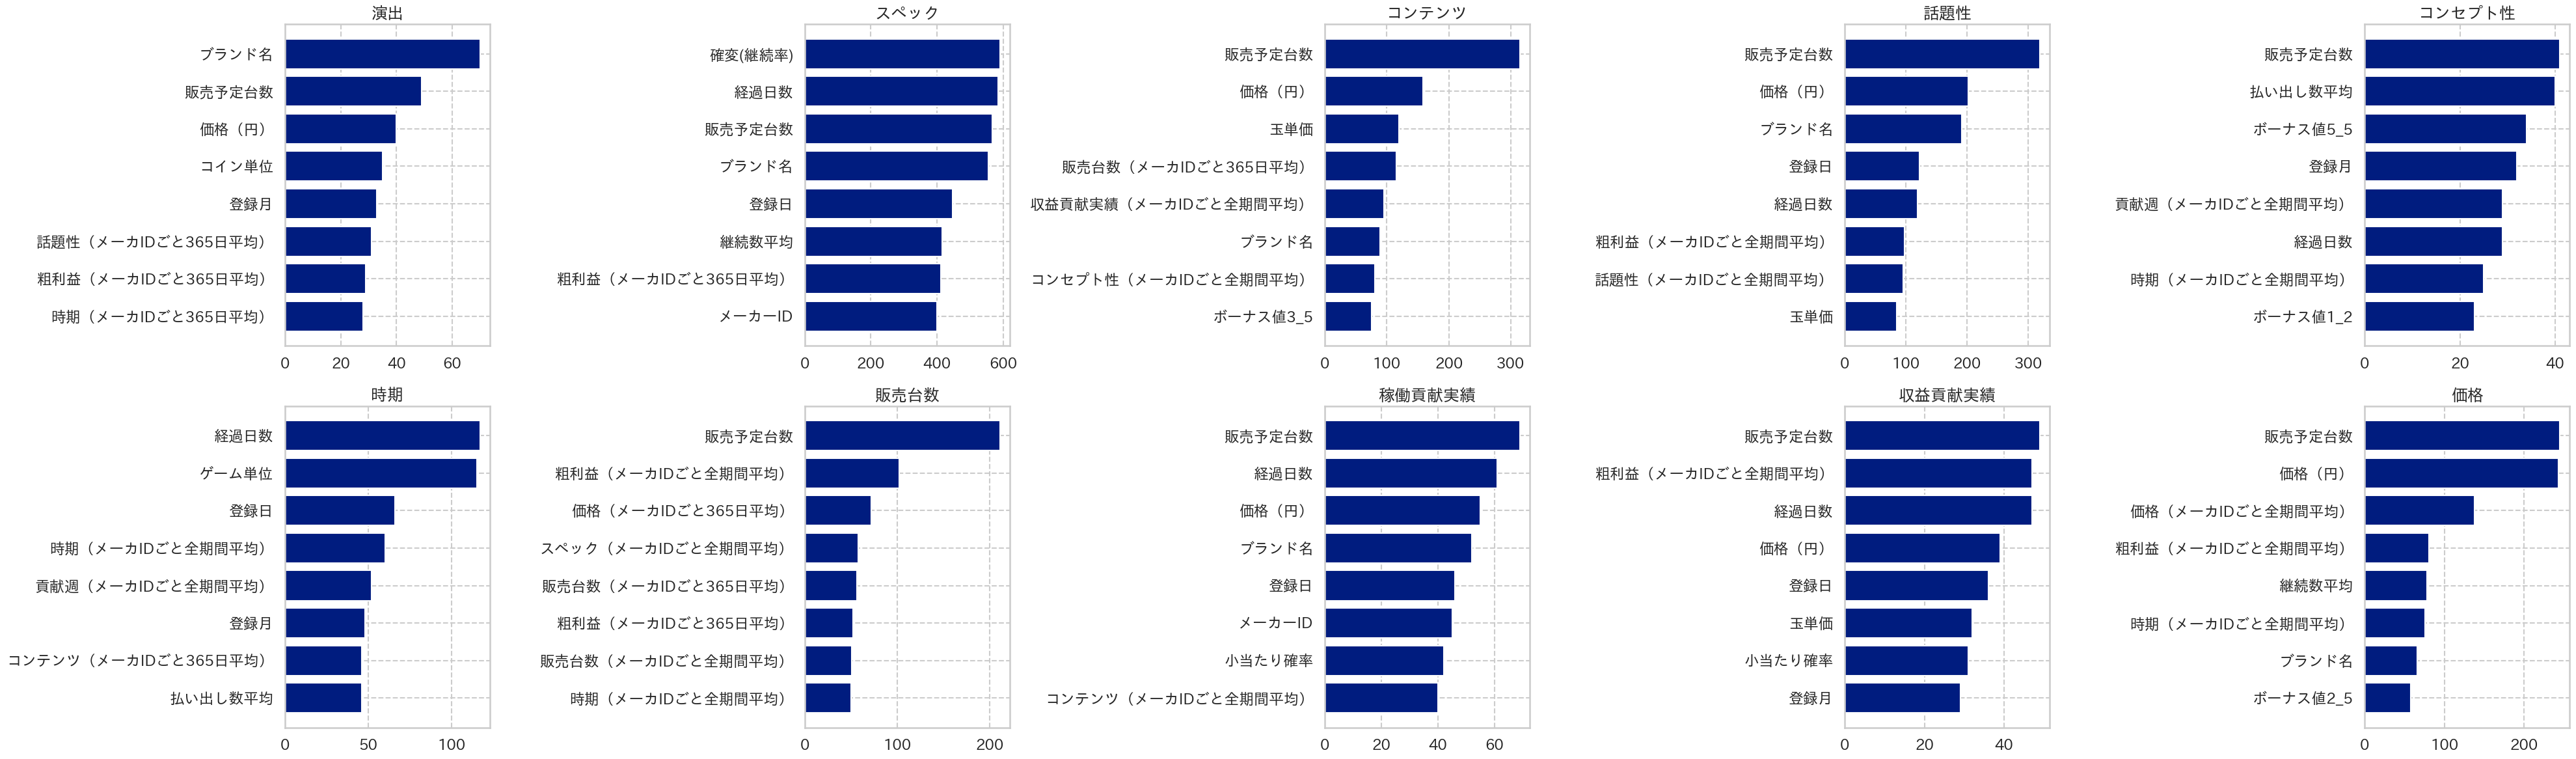

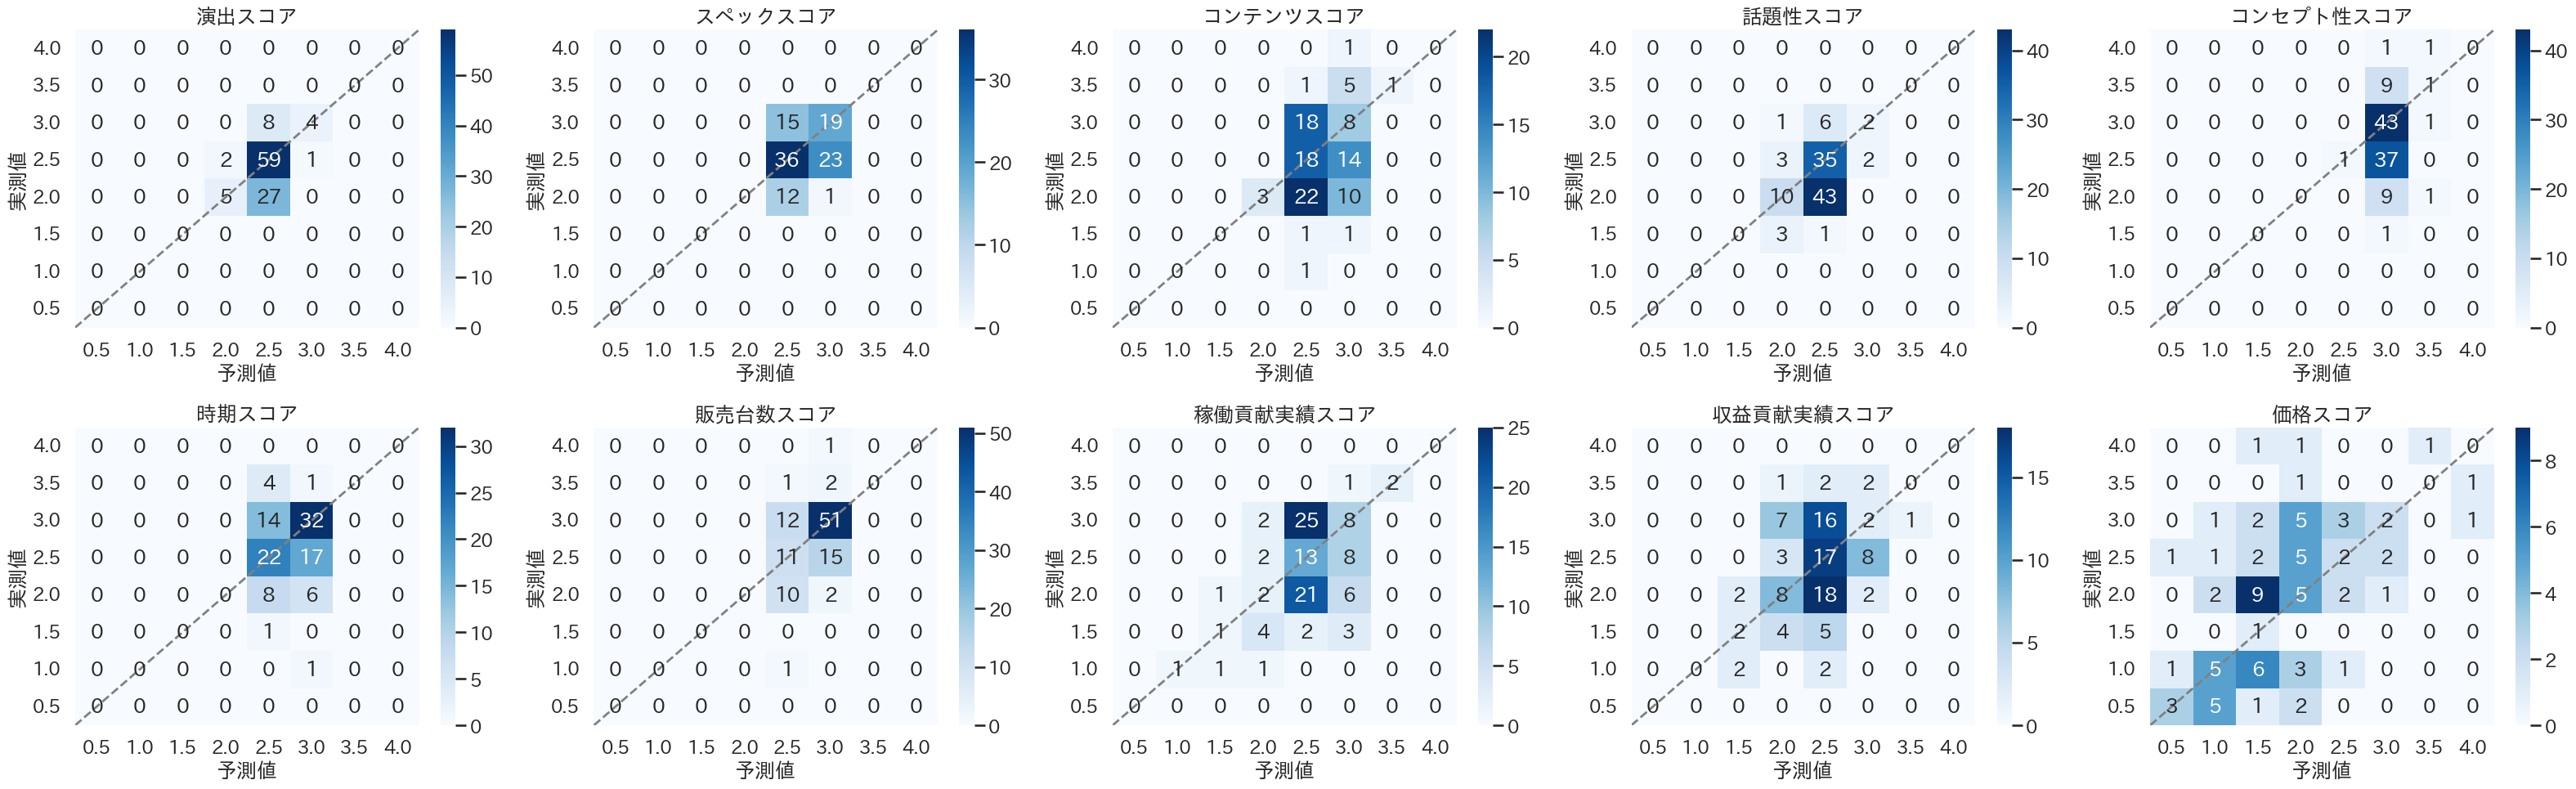

In [9]:
from src.evaluation import evaluation
eval = evaluation(None, None)
df_all_kinds, df_slot, df_pachinko = eval.evaluate_all(df_output_gbm, targets, eval_types=['r2', 'rmse'])
fig_importance = eval.plot_feature_importance(models_gbm, targets, features, N=8)
fig_heatmap = eval.make_multiple_heatmaps(df_output_gbm, 0, 4, 9, targets)

df_all_kinds.to_csv(folder + '/評価_全体.csv', index=False) 
df_slot.to_csv(folder + '/評価_スロット.csv', index=False) 
df_pachinko.to_csv(folder + '/評価_パチンコ.csv', index=False) 

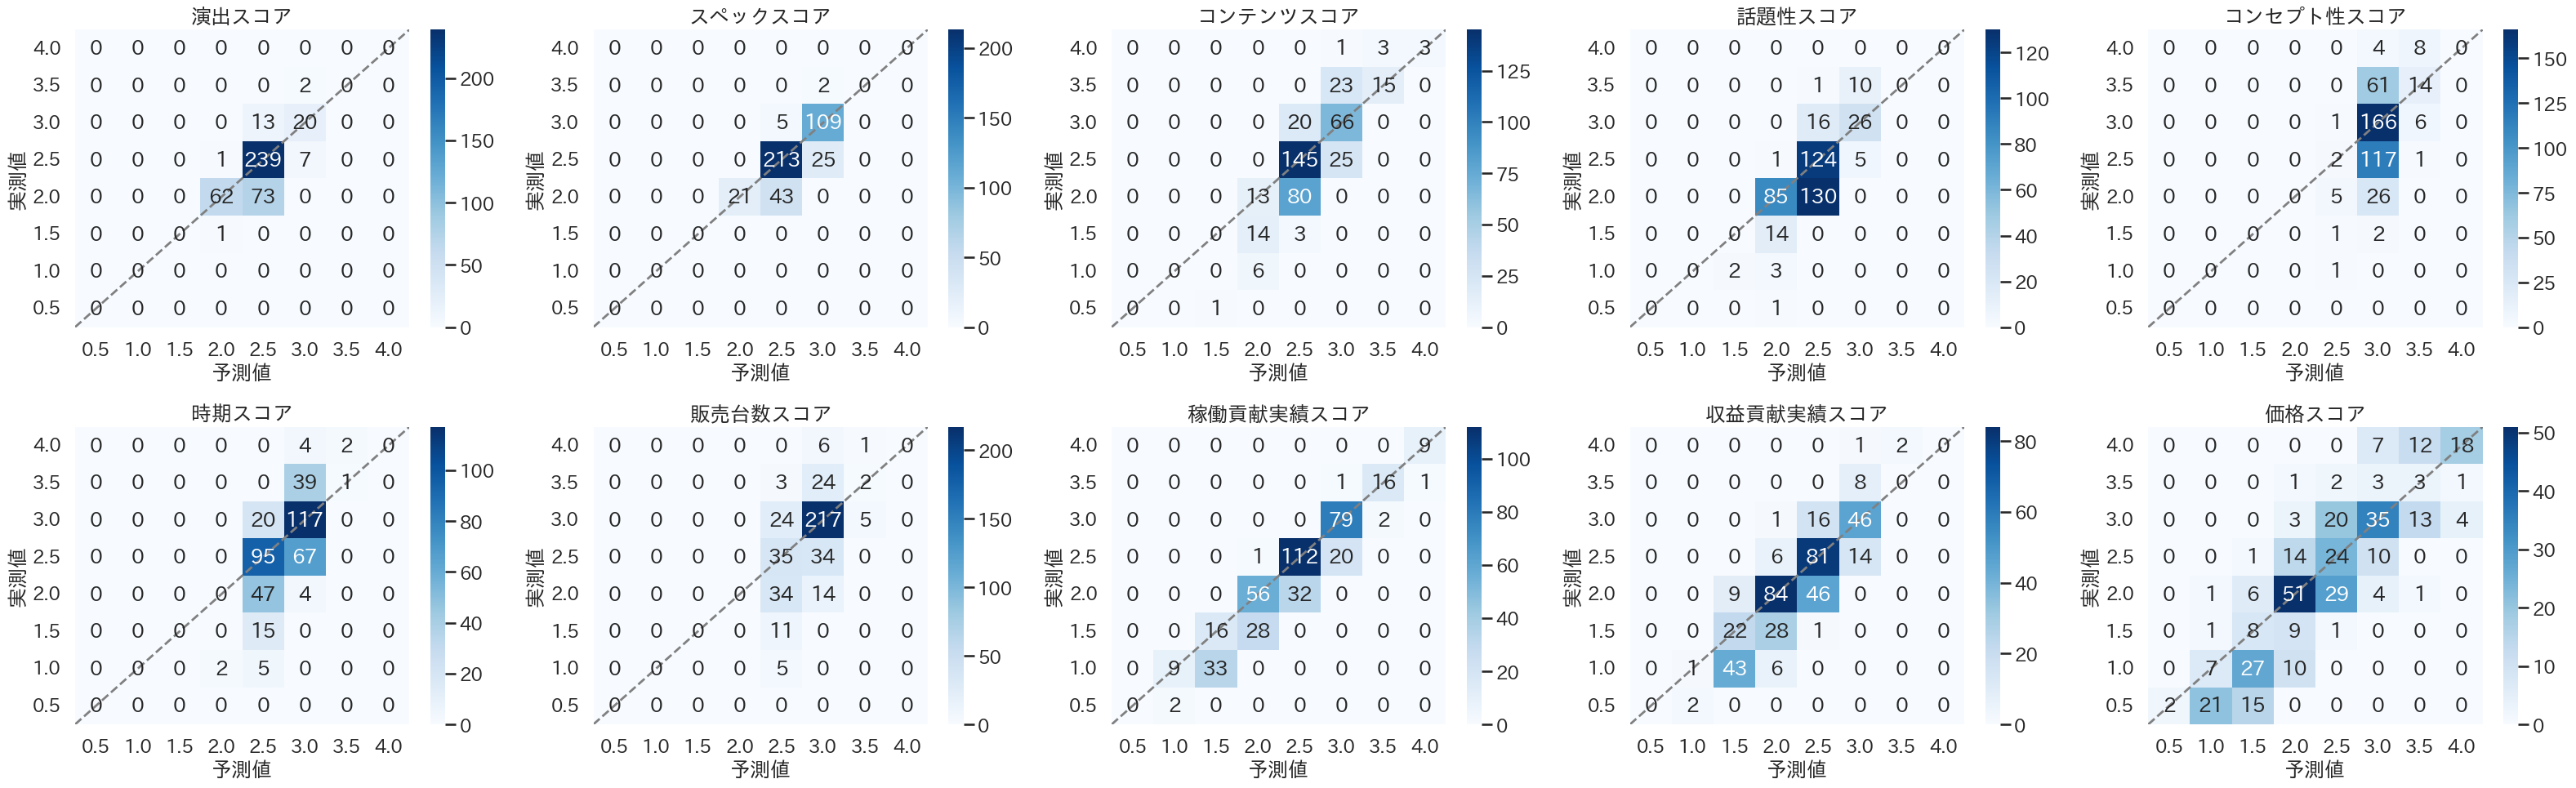

In [55]:
# 学習データ
fig_heatmap = eval.make_multiple_heatmaps(df_output_gbm_train, 0, 4, 9, targets)

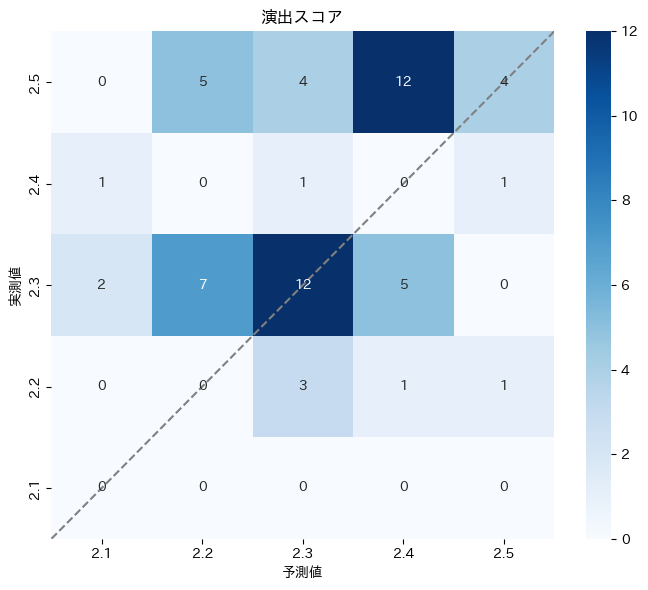

In [8]:
from data_columns.en_jp_dictionary import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

eval = evaluation(None, None)

title = 'Performance'

confusion_matrix = eval.create_confusion_matrix(df_output_gbm.copy(), 2, 2.5, 6, title)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title(f"{targets_jp[title]}スコア")

# 対角線に線を追加
labels = np.linspace(2, 2.5, 6)
n = len(labels)
ax.plot(range(n+1), n - 1 - np.array(range(n+1)), linestyle='--', color='gray')

ax.set_xticklabels([f"{label:.1f}" for label in labels[1:]], rotation=0)
ax.set_yticklabels(np.flip([f"{label:.1f}" for label in labels[1:]]))

ax.set_xlabel('予測値')
ax.set_ylabel('実測値')

plt.tight_layout()
plt.show()

# 貢献週と粗利益予測

In [9]:
df = df[df['GrossProfit'] > 0]
df = df[df['ModelLife'] > 0]

In [10]:
import pandas as pd

# 学習とテストデータの定義
df_train = df[df['Regist_Date'] < df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]
df_test = df[df['Regist_Date'] >= df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]

## ハイパーパラメータチューニング

In [43]:
import importlib
import sys
importlib.reload(sys.modules[model_tuning.__module__])

from src.hyperparameters_tuning import model_tuning

mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_profit_lightgbm_20240902.json')

output = mt_gbm.search_parameters(features,
                   ['ModelLife', 'GrossProfit'],
                   df_train,
                   model_kind='lightgbm_regressor_poisson',
                   n_trials=1000, loss='rmse', n_searches=5,
                   random_states=[42, 34, 10, 2, 234]) 

--------------
検索 1 回目
最適化: minimize  rmse
--- ModelLife ---
trial: 668
evaluation : 10.386859175511601
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 6, 'learning_rate': 0.09499885167591557, 'n_estimators': 873, 'min_child_samples': 10, 'min_child_weight': 0.03646484257906249, 'subsample': 0.8550094905291683, 'colsample_bytree': 0.5421059700086703, 'reg_alpha': 1.934611069122109, 'reg_lambda': 0.6219683774897404, 'max_bin': 196, 'lambda_l1': 0.4284951569524701, 'lambda_l2': 1.6506915164165308}
--- GrossProfit ---
trial: 934
evaluation : 334479.4546264015
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 9, 'learning_rate': 0.24024703111533557, 'n_estimators': 270, 'min_child_samples': 25, 'min_child_weight': 0.014359263399292605, 'subsample': 0.888899136688743, 'colsample_bytree': 0.6898312156501618, 'reg_alpha': 0.2755848628306146, 'reg_lambda': 1.3691266237891815, 'max_bin': 185, 'lambda_l1': 0.7912415689315063, 'lambda_l2': 1.0904095068014414}
-

In [11]:
from src.modeling import modeling
from src.evaluation import evaluation

# 出力のフォルダ場所
folder = 'output_train/output_20240903'

###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets=['ModelLife', 'GrossProfit'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm_20240902.json',
                              model_kind='lightgbm_regressor')
df_output_profit_gbm = m.predict_all(models_profit_gbm, df_test)
df_output_profit_gbm_train = m.predict_all(models_profit_gbm, df_train)

In [12]:
def categorize_modellife(x):
    if x >= 0 and x <= 6:
        return 1
    elif x >= 7 and x <= 9:
        return 2
    elif x >= 10 and x <= 13:
        return 3
    elif x >= 14 and x <= 17:
        return 4
    else:
        return 5

def categorize_grossprofit(x):
    if x <= 200000:
        return 1
    elif x > 200000 and x <= 300000:
        return 2
    elif x > 300000 and x <= 400000:
        return 3
    elif x > 400000 and x <= 600000:
        return 4
    elif x > 600000 and x <= 800000:
        return 5
    else:
        return 6


for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output_profit_gbm[target+'_category' + '_pred'] = df_output_profit_gbm[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm[target+'_category'] = df_output_profit_gbm[target].apply(lambda x : func(x))

    df_output_profit_gbm_train[target+'_category' + '_pred'] = df_output_profit_gbm_train[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm_train[target+'_category'] = df_output_profit_gbm_train[target].apply(lambda x : func(x))

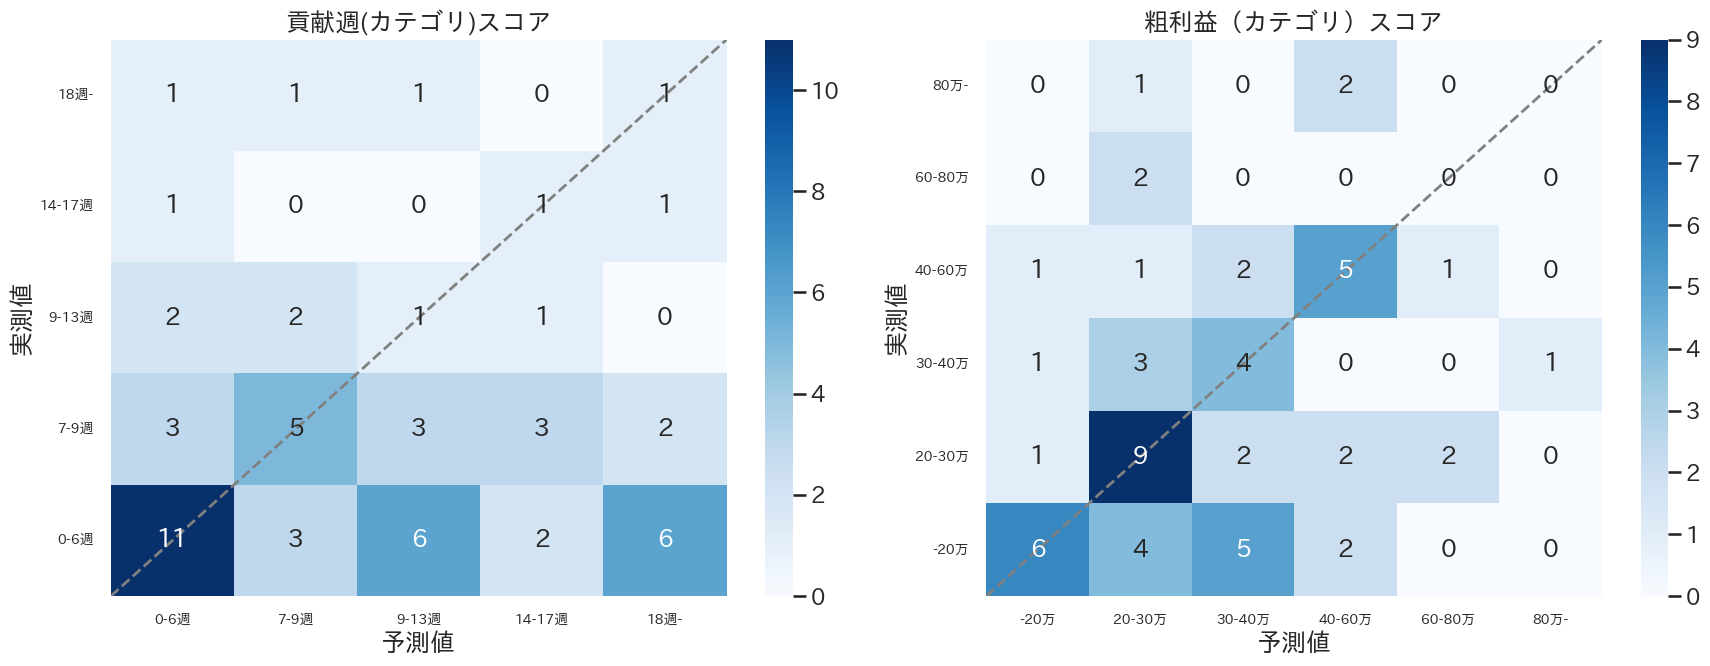

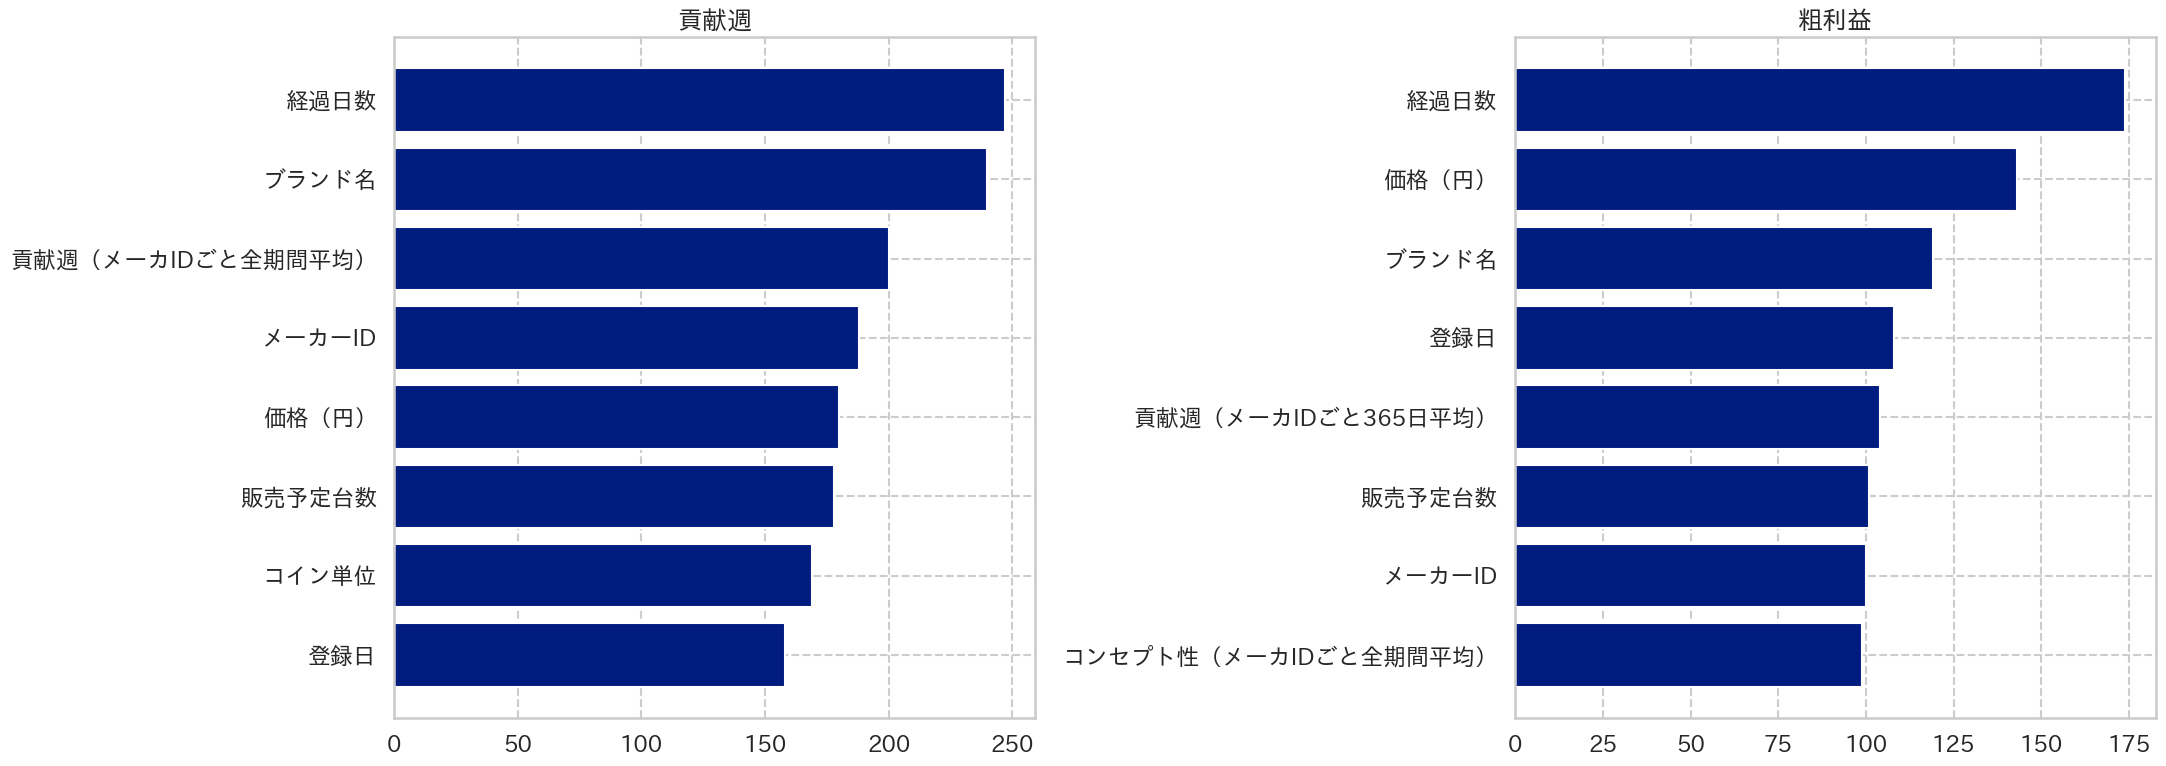

In [14]:
from src.evaluation import evaluation
eval = evaluation(None, None)

df_all_kinds, df_slot, df_pachinko = eval.evaluate_all(df_output_profit_gbm, targets=['ModelLife_category', 'GrossProfit_category'],
                                                       eval_types=['accuracy', 'rmse'])

tick_labels = [['0-6週', '7-9週', '9-13週', '14-17週', '18週-'],
   ['-20万', '20-30万', '30-40万', '40-60万','60-80万', '80万-']]

fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)

fig_importance = eval.plot_feature_importance(models_profit_gbm, targets=['ModelLife', 'GrossProfit'],
                                features=features, N=8, fig_N_rows=1, fig_N_cols=2, figsize=(22, 8))


df_all_kinds.to_csv(folder + '/評価_profit_全体.csv', index=False) 
df_slot.to_csv(folder + '/評価_profit_スロット.csv', index=False) 
df_pachinko.to_csv(folder + '/評価_profit_パチンコ.csv', index=False) 

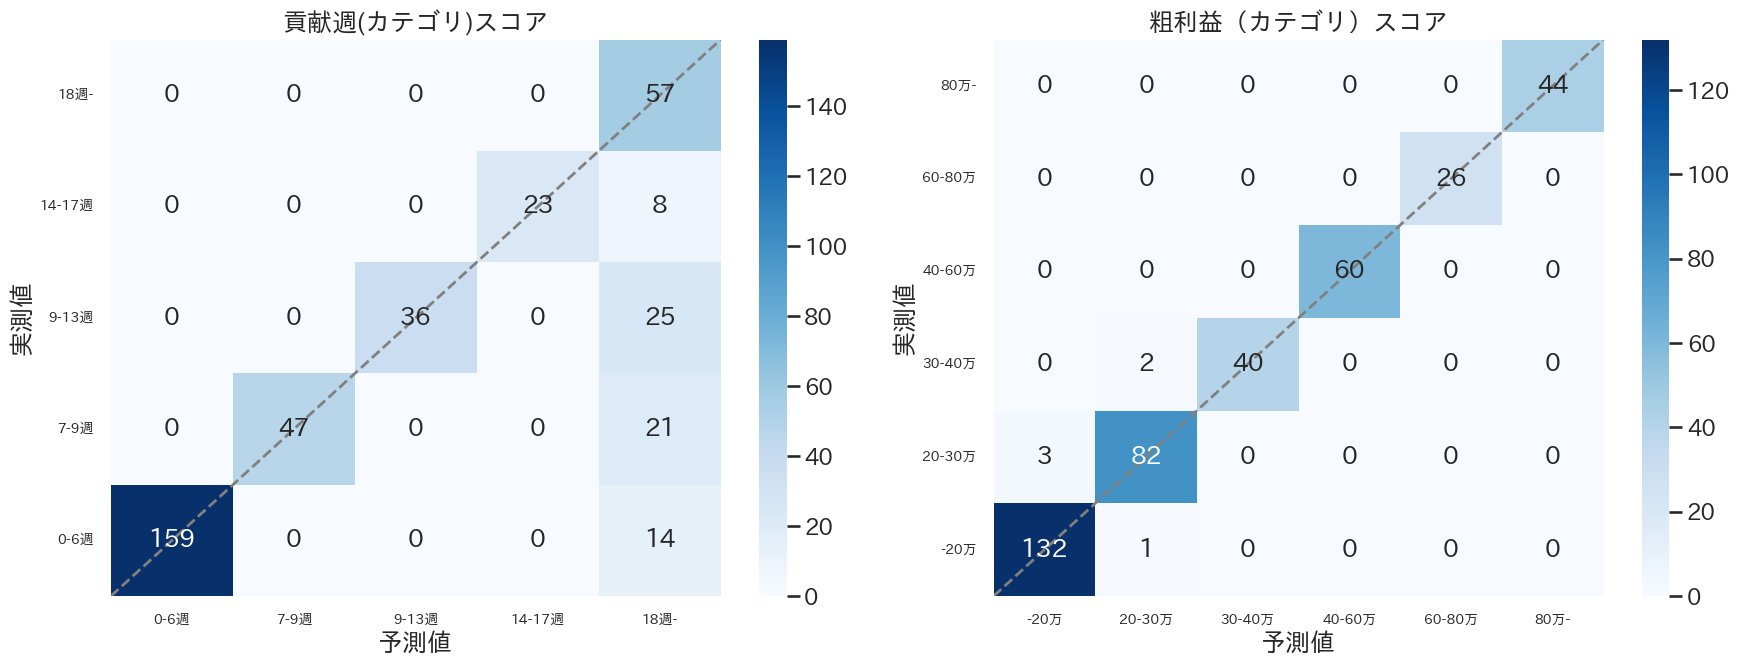

In [63]:
# 学習データ
fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm_train.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)

# 時系列でみる

In [13]:
df_time = pd.concat([df_test[['Regist_Date_year', 'Regist_Date_month']], df_output_profit_gbm], axis=1)

In [14]:
df_modellife = df_time[['Regist_Date_year', 'Regist_Date_month', 'ModelLife_pred']].groupby(['Regist_Date_year', 'Regist_Date_month']).mean()['ModelLife_pred'].reset_index()
df_modellife_all = df[['Regist_Date_year', 'Regist_Date_month', 'ModelLife']].groupby(['Regist_Date_year', 'Regist_Date_month']).mean()['ModelLife'].reset_index()

df_modellife['yyyymm'] = pd.to_datetime(df_modellife['Regist_Date_year'].astype(str) + '/' + df_modellife['Regist_Date_month'].astype(str))
df_modellife_all['yyyymm'] = pd.to_datetime(df_modellife_all['Regist_Date_year'].astype(str) + '/' + df_modellife_all['Regist_Date_month'].astype(str))

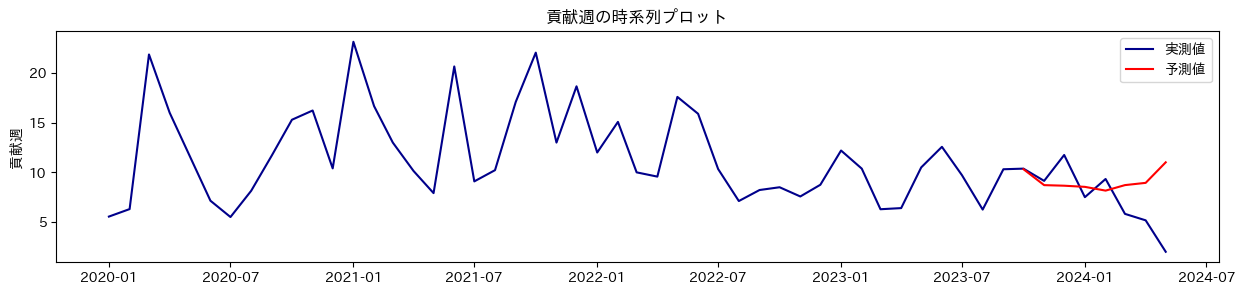

In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_palette("pastel")

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(df_modellife_all['yyyymm'], df_modellife_all['ModelLife'],color='darkblue', label='実測値')
ax.plot(df_modellife['yyyymm'], df_modellife['ModelLife_pred'],color='red', label='予測値')
ax.set_ylabel("貢献週")
ax.set_title('貢献週の時系列プロット')
ax.legend()

In [18]:
df_grossprofit = df_time[['Regist_Date_year', 'Regist_Date_month', 'GrossProfit_pred']].groupby(['Regist_Date_year', 'Regist_Date_month']).mean()['GrossProfit_pred'].reset_index()
df_grossprofit_all = df[['Regist_Date_year', 'Regist_Date_month', 'GrossProfit']].groupby(['Regist_Date_year', 'Regist_Date_month']).mean()['GrossProfit'].reset_index()

df_grossprofit['yyyymm'] = pd.to_datetime(df_grossprofit['Regist_Date_year'].astype(str) + '/' + df_grossprofit['Regist_Date_month'].astype(str))
df_grossprofit_all['yyyymm'] = pd.to_datetime(df_grossprofit_all['Regist_Date_year'].astype(str) + '/' + df_grossprofit_all['Regist_Date_month'].astype(str))

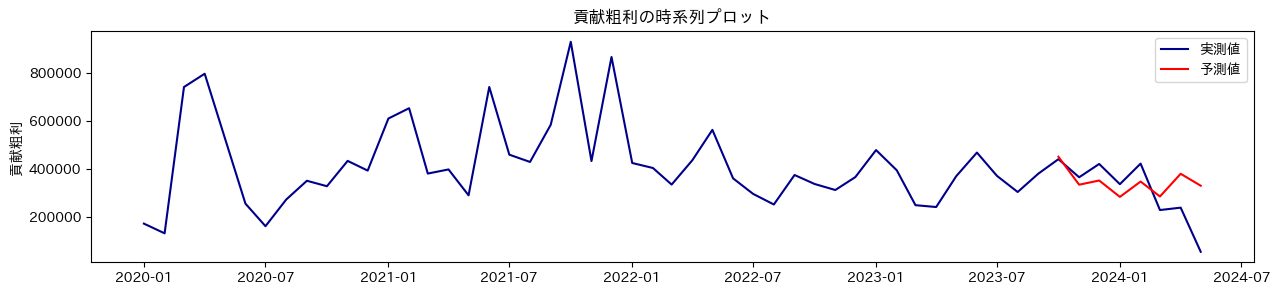

In [27]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(df_grossprofit_all['yyyymm'], df_grossprofit_all['GrossProfit'],color='darkblue', label='実測値')
ax.plot(df_grossprofit['yyyymm'], df_grossprofit['GrossProfit_pred'],color='red', label='予測値')
ax.set_ylabel("貢献粗利")
ax.set_title('貢献粗利の時系列プロット')
ax.legend()